# Обучение модели классификации комментариев

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Борьба-с-дисбалансом-классов" data-toc-modified-id="Борьба-с-дисбалансом-классов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Борьба с дисбалансом классов</a></span><ul class="toc-item"><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Upsampling</a></span></li></ul></li><li><span><a href="#Подбор-гиперпараметров-различных-моделей" data-toc-modified-id="Подбор-гиперпараметров-различных-моделей-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подбор гиперпараметров различных моделей</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении имеется набор данных с разметкой о токсичности правок.

Требование к метрике качества модели *F1* не меньше 0.75. 

**План по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except FileNotFoundError: 
    data = pd.read_csv('datasets/toxic_comments.csv')

In [5]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
data.toxic.mean()

0.10167887648758234

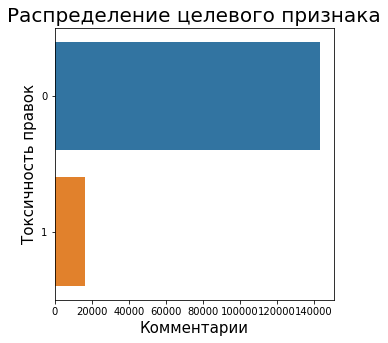

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(y="toxic", data=data)
plt.xlabel('Комментарии', fontsize=15)
plt.ylabel('Токсичность правок', fontsize=15)
plt.title('Распределение целевого признака', fontsize=20);

In [9]:
#Проверим как работает лемматизация с помощью spacy.
corpus = data['text'].values
nlp = spacy.load("en_core_web_sm")
doc = nlp(corpus[0])
lem = ' '.join([token.lemma_ for token in doc])


print("Исходный текст:", corpus[0])
print("Лемматизированный текст:", lem)

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Лемматизированный текст: Explanation 
 why the edit make under my username Hardcore Metallica Fan be revert ? they be not vandalism , just closure on some gas after I vote at New York Dolls FAC . and please do not remove the template from the talk page since I be retire now.89.205.38.27


In [10]:
#Создаем функцию для лемматизации и применяем ко всему тексту.
def lemmatize(text):
    """Функция лемматизирует текст"""
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [11]:
data['lem_text'] = data.text.apply(lemmatize)

In [12]:
data

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation \n why the edit make under my user...
1,D'aww! He matches this background colour I'm s...,0,D'aww ! he match this background colour I be s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n More \n I can not make any real suggestio..."
4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,""" : : : : : and for the second time of asking ..."
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself \n\n that be...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,"spitzer \n\n Umm , there s no actual article f..."
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [13]:
#Удаляем лишние символы.
def clear_text(text):
    """Функция очищает текст от лишних символов"""
    resub = re.sub(r'[^a-zA-Z]', ' ', text)
    return ' '.join(resub.split())

In [14]:
data['lem_text'] = data.lem_text.apply(clear_text)

In [15]:
data

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer Umm there s no actual article for pros...
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


Текст лемматизирован, лишние символы удалены. Разделим данные на выборки.

## Обучение

In [37]:
features = data.lem_text
target = data.toxic

In [38]:
features_train, features_, target_train, target_ = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_, target_, test_size=0.5, random_state=12345)
print('Размеры обучающей выборки:', features_train.shape, target_train.shape)
print('Размеры валидационной выборки:', features_valid.shape, target_valid.shape)
print('Размеры тестовой выборки:', features_test.shape, target_test.shape)

Размеры обучающей выборки: (95742,) (95742,)
Размеры валидационной выборки: (31914,) (31914,)
Размеры тестовой выборки: (31915,) (31915,)


Вычислим TF-IDF для корпусов текстов.

In [39]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
corpus_train = features_train.values
corpus_valid = features_valid.values
corpus_test = features_test.values

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test) 

Теперь тестируем различные модели и подбираем параметры.

### Логистическая регрессия

In [41]:
result_df = pd.DataFrame(columns=['Balance', 'F1'])
result_df

,Balance,F1


In [42]:
def result_write(model_name, balance, f1):
    """Функция записывает результаты предсказания в таблицу"""
    result_df.loc[model_name,'Balance'] = balance
    result_df.loc[model_name,'F1'] = round(f1, 3)
    return result_df

In [56]:
model = LogisticRegression(random_state=12345) 
model.fit(tf_idf_train, target_train)
f1_metrics = f1_score(target_valid,  model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии:', f1_metrics)

F1 метрика для логистической регрессии: 0.7349509168364512


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
result_write('LogisticRegression', 'no', f1_metrics)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752


In [58]:
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(tf_idf_train, target_train) 
f1_metrics = f1_score(target_valid, model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии, классы сбалансированы:', f1_metrics)

F1 метрика для логистической регрессии, классы сбалансированы: 0.7515595334960672


In [59]:
result_write('LogisticRegression_2', "class_weight='balanced'", f1_metrics)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752


### Борьба с дисбалансом классов

#### Downsampling

Попробуем изменить баланс в классификации уменьшением выборки.

In [78]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [79]:
features_downsampled.shape

(18352,)

In [80]:
target_downsampled.mean()

0.5314407149084568

In [81]:
features_train.shape

(95742,)

In [82]:
target_train.mean()

0.10186751895719746

In [83]:
corpus_train_ds = features_downsampled.values
corpus_valid = features_valid.values
corpus_test = features_test.values

tf_idf_train_ds = count_tf_idf.fit_transform(corpus_train_ds) 
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test) 

In [68]:
print(tf_idf_train)

  (0, 112631)	0.08354008466832895
  (0, 21497)	0.1395724589546736
  (0, 101593)	0.0935565819275253
  (0, 32269)	0.28221354765672635
  (0, 80548)	0.22444929777856293
  (0, 80976)	0.29804470330891963
  (0, 78041)	0.3166727867023809
  (0, 18815)	0.171725404579725
  (0, 33545)	0.6843392261106394
  (0, 114784)	0.2573641692410328
  (0, 69510)	0.23922386546282393
  (0, 43637)	0.15613875810468197
  (1, 42550)	0.06669899520952031
  (1, 78675)	0.057551822180650275
  (1, 20813)	0.0978714254679161
  (1, 85197)	0.09127655315214488
  (1, 113781)	0.0753798093549765
  (1, 45039)	0.0835954424236027
  (1, 85159)	0.04841277409679576
  (1, 25458)	0.08814492868878097
  (1, 113249)	0.05629100527573239
  (1, 63459)	0.06980651728319252
  (1, 7980)	0.074042892320821
  (1, 79184)	0.06982603486130498
  (1, 34313)	0.060515788534195994
  :	:
  (95741, 113751)	0.24901662826627669
  (95741, 71460)	0.1000047878250906
  (95741, 37601)	0.1285617783644122
  (95741, 24886)	0.11801715106314573
  (95741, 111503)	0.16089888

In [70]:
features_train

17152     Happy New Year EuroCarGT class plainlink EuroC...
59065     speedy deletion of Mahur Malie and Masahet a t...
29        a barnstar for you the Real Life Barnstar let ...
31000                  the article s self appoint caretaker
90595     review to add paste here for now http theearly...
                                ...                        
109993    Gam keep your CRAP off my Talk page your KKK s...
85412                             I correct what you listed
133249    hmm yes as I say I also watch the Emily Ruete ...
130333                          kinda like miachael jackson
77285     criterion for deletion I be just wonder what b...
Name: lem_text, Length: 95742, dtype: object

In [89]:
model_ = LogisticRegression(random_state=12345) 
model.fit(tf_idf_train_ds, target_downsampled) 
f1_metrics = f1_score(target_valid, model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии:', f1_metrics)

F1 метрика для логистической регрессии: 0.6632917353425947


In [97]:
result_write('LogisticRegression_3', "downsampling", f1_metrics)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663


Случайный лес

In [98]:
best_result = 0
max_depth = 0
max_n_est = 0
for depth in range(10, 15):
    for n_est in range(50, 301, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=n_est,  random_state=12345)
        model.fit(tf_idf_train_ds, target_downsampled)
        result = f1_score(target_valid, model.predict(tf_idf_valid))
        if result > best_result:
            best_result = result 
            max_depth = depth
            max_n_est = n_est
            
            
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)
print("Число деревьев:", max_n_est) 


F1 наилучшей модели на валидационной выборке: 0.29170247302587604
Максимальная глубина: 14
Число деревьев: 300


In [99]:
result_write('Random_Forest', "downsampling", best_result)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292


Метрики стали хуже, попробуем увеличить обучающую выборку.

#### Upsampling

In [100]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [101]:
target_upsampled.mean()

0.5314436107433018

In [102]:
features_upsampled.shape

(183519,)

In [104]:
corpus_train_us= features_upsampled.values
corpus_valid = features_valid.values
corpus_test = features_test.values

tf_idf_train_us = count_tf_idf.fit_transform(corpus_train_us) 
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test) 

In [105]:
model = LogisticRegression(random_state=12345) 
model.fit(tf_idf_train_us, target_upsampled)
f1_metrics =  f1_score(target_valid, model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии:', f1_metrics)

F1 метрика для логистической регрессии: 0.7441609288510868


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
result_write('LogisticRegression_4', "upsampling", f1_metrics)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744


Случаный лес.

In [110]:
best_result = 0
max_depth = 0
max_n_est = 0
for depth in range(10, 15):
    for n_est in range(50, 301, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=n_est,  random_state=12345)
        model.fit(tf_idf_train_us, target_upsampled)
        result = f1_score(target_valid, model.predict(tf_idf_valid))
        if result > best_result:
            best_result = result 
            max_depth = depth
            max_n_est = n_est
            
            
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)
print("Число деревьев:", max_n_est) 


F1 наилучшей модели на валидационной выборке: 0.26943141466836174
Максимальная глубина: 14
Число деревьев: 300


In [113]:
result_write('Random_Forest_2', "upsampling", best_result)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744
Random_Forest_2,upsampling,0.269


Результат значительно не улучшился, вернем выборку к исходному размеру, попробуем другие модели.

### Подбор гиперпараметров различных моделей

In [114]:
corpus_train = features_train.values
corpus_valid = features_valid.values
corpus_test = features_test.values

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test) 

In [115]:
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                                random_state=12345, class_weight='balanced') 
model.fit(tf_idf_train, target_train) 
f1_metrics =  f1_score(target_valid, model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии:', f1_metrics)

F1 метрика для логистической регрессии, классы сбалансированы: 0.7458533975387909


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [116]:
model_lr = LogisticRegression(penalty='l2', solver='newton-cg', class_weight='balanced',
                                random_state=12345) 
model_lr.fit(tf_idf_train, target_train) 
f1_metrics =  f1_score(target_valid, model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии:', f1_metrics)

F1 метрика для логистической регрессии: 0.7458533975387909


In [117]:
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced',
                                random_state=12345) 
model_lr.fit(tf_idf_train, target_train) 
f1_metrics =  f1_score(target_valid, model.predict(tf_idf_valid))
print('F1 метрика для логистической регрессии:', f1_metrics)

F1 метрика для логистической регрессии: 0.7458533975387909


In [118]:
# Дерево решений
best_result = 0
max_depth = 0
for depth in range (1, 20):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(tf_idf_train, target_train)
    result = f1_score(target_valid, model.predict(tf_idf_valid))
    if result > best_result:
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)


F1 наилучшей модели на валидационной выборке: 0.6561234329797492
Максимальная глубина: 18


In [119]:
result_write('Decision_Tree', "no", best_result)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744
Random_Forest_2,upsampling,0.269
Decision_Tree,no,0.656


In [120]:
# Дерево решений с учетом дисбаланса
best_result = 0
max_depth = 0
for depth in range (1, 20):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(tf_idf_train, target_train)
    result = f1_score(target_valid, model.predict(tf_idf_valid))
    if result > best_result:
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)


F1 наилучшей модели на валидационной выборке: 0.6357711803041275
Максимальная глубина: 19


In [121]:
result_write('Decision_Tree_2', "class_weight='balanced'", best_result)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744
Random_Forest_2,upsampling,0.269
Decision_Tree,no,0.656
Decision_Tree_2,class_weight='balanced',0.636


In [122]:
#Случайный лес
best_result = 0
max_depth = 0
max_n_est = 0
for depth in range(10, 15):
    for n_est in range(50, 301, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=n_est,  
                                       random_state=12345, class_weight='balanced')
        model.fit(tf_idf_train, target_train)
        result = f1_score(target_valid, model.predict(tf_idf_valid))
        if result > best_result:
            best_result = result 
            max_depth = depth
            max_n_est = n_est
            
            
print()
print("F1 наилучшей модели, Случайный лес:", best_result)
print("Максимальная глубина:", max_depth)
print("Число деревьев:", max_n_est) 


F1 наилучшей модели, Случайный лес: 0.3887363604364661
Максимальная глубина: 14
Число деревьев: 250


In [124]:
result_write('Random_forest_3', "class_weight='balanced'", best_result)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744
Random_Forest_2,upsampling,0.269
Decision_Tree,no,0.656
Decision_Tree_2,class_weight='balanced',0.636
Random_forest_3,class_weight='balanced',0.389


In [123]:
#LightGBM
model = lgb.LGBMClassifier(num_leaves=31,learning_rate=0.2, n_estimators=170)
model.fit(tf_idf_train, target_train)
F1 = f1_score(target_valid, model.predict(tf_idf_valid))
print("F1 =", F1)

F1 = 0.7710719781159171


In [126]:
result_write('LightGBM', "no",F1)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744
Random_Forest_2,upsampling,0.269
Decision_Tree,no,0.656
Decision_Tree_2,class_weight='balanced',0.636
Random_forest_3,class_weight='balanced',0.389
LightGBM,no,0.771


По результатам подбора наилучшие результаты показала модель LGBM,  f1 = 0,77 на валидационной выборке. Проверяем ее на тестовой выборке.

In [127]:
model = lgb.LGBMClassifier(num_leaves=31,learning_rate=0.2, n_estimators=170)
model.fit(tf_idf_train, target_train)
F1 = f1_score(target_test, model.predict(tf_idf_test))
print("F1 =", F1)

F1 = 0.7759791122715405


## Выводы

Мы обучили модель классифицировать комментарии на позитивные и негативные. Наилучшие результаты показала модель LGBM. Значение метрики качества F1 на тестовой выборке 0,77, что превышает требуемые 0,75.

In [128]:
result_write('LightGBM тестовая выборка', "no", F1)

,Balance,F1
LogisticRegression,no,0.735
LogisticRegression_2,class_weight='balanced',0.752
LogisticRegression_3,downsampling,0.663
Random_Forest,downsampling,0.292
LogisticRegression_4,upsampling,0.744
Random_Forest_2,upsampling,0.269
Decision_Tree,no,0.656
Decision_Tree_2,class_weight='balanced',0.636
Random_forest_3,class_weight='balanced',0.389
LightGBM,no,0.771
